## Step 1 - Clean and prepare data

In [ ]:
# import packages
import numpy as np
import pandas as pd
from scipy import stats
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# import data
dfclass = pd.read_csv('/kaggle/input/classification/exercise_05_train.csv')
X = dfclass.drop(columns = ['y'])
y = dfclass['y'] 

In [ ]:
# check if duplication
print('Dataset has', X.duplicated().sum(), ' duplications') #0
# check data shape
print('Datashape as', X.shape) # 100 attributes, may need dimensional reduction
# check response balancy
from collections import Counter
print('Response counts as ', Counter(y)) # Counter({0: 31853, 1: 8147}) Not severely imbalanced
# check missing value
missing_data = [x for x in X.columns if sum(X[x].isnull()) > 0]
mis = pd.DataFrame(X[missing_data].dtypes)
mis['prec'] = [100*(sum(X[i].isnull())/X.shape[0]) for i in missing_data]
print('Dataset has ', len(missing_data), ' columns of missing value no more than', mis.T.iloc[1].max(), '%' )
mis.T

### Numerical data EDAs
- summary
- missing value
- outliers



x41 and x45 are numerical data with $sign or %, convert to numerical then treat as numerical

In [ ]:
X.x41 = X.x41.astype(str).str.strip('$').astype(float)
X.x45 = X.x45.astype(str).str.strip('%').astype(float)

In [ ]:
# check summary of numerical data
print('Number of numerical cols ', len(X.select_dtypes(np.number).columns))
pd.DataFrame(X.describe(include = [np.number]))

#### impute missing value
What value to impute depends on data, impute mean/median for age or weight which could not be 0, while absense for certain attributes should be treat as 0 

Since there is no further information about the data, assume :
- if original conatins 0, impute 0
- else if attributes standard deviation is large (could potentialy contain outliers), impute median
- else impute mean

In [ ]:
# impute with 0
print('column ', X.columns[(X.T==0).any(1)].tolist(), 'contains ', 100*(sum(X.x45==0)/X.x45.shape[0]), '% of 0')
# column 45 contains 39% of 0, impute na with 0
X.x45.fillna(0, inplace = True)
print('x45 still has missing?', X.x45.isna().any())

In [ ]:
# impute with median
# assumption: CV = std/mean >1 then high (if mean is too small then only look at std value), impute median
spread_x_median = pd.DataFrame(X.std().sort_values(ascending=False)[((X.std()/X.mean()>1) & (X.mean()>1))|(X.std()>=50)])
spread = spread_x_median.T.columns
X[spread] = X[spread].fillna(X[spread].median())
spread_x_median.T

In [ ]:
# impute rest with median
X = X.fillna(X.mean())

#### outliers
Wether delete or not outliers depending on assumption and source of outlier

Since there is no further information about the data, assume :
- if outliers are for both sides and do not impact response y, keep them
- else if outliers all in the same row, data quality delete row or replace with mean

In [ ]:
num_col = X.select_dtypes(np.number).columns
# identify outliers with upper and lower whisker 
q1 = X[num_col].quantile(0.25)
q3 = X[num_col].quantile(0.75)
iqr = q3 - q1
upw = q3+1.5*iqr
low = q1-1.5*iqr
# find attributes with most outliers
num_col = X.select_dtypes(np.number).columns
dfa = X[num_col][(X[num_col]<(low))|(X[num_col]>upw)]
dfa.head(5) # outliers are spreaded out among different rows
md = [x for x in dfa.columns if sum(dfa[x].isnull()) > 0]
ms = pd.DataFrame(dfa[md].dtypes)
ms['prec'] = [100*(1- sum(dfa[i].isnull())/dfa.shape[0]) for i in md]
ms['prec'].sort_values(ascending = False).head(3)
# attribute with max outliers has <1.5% outliers

In [ ]:
# outliers distribution with boxplot
#import warnings
warnings.filterwarnings('ignore')
boxp = X[['x44' ,'x75', 'x69']]
boxp['y'] = y
boxplot = boxp.boxplot(by='y', layout = (1,6), figsize = (30 , 10), fontsize = 20)

In [ ]:
import warnings
print(dfclass.corr()['y'].sort_values(ascending =False).head(4))
warnings.filterwarnings('ignore')
boxp = X[['x97', 'x58', 'x1']]
boxp['y'] = y
boxplot = boxp.boxplot(by='y', layout = (1,6), figsize = (30 , 10), fontsize = 20)

Outliers seemed to be distributed on both side, even for highly correlated attributes, outliers seemed not impacting the response. Not to delete outliers

### Categorical data EDAs
- summary
- missing value
- enode


x41 and x45 are numerical data with $sign or %, convert to numerical then treat as numerical

In [ ]:
cat_col = X.select_dtypes(np.object).columns
pd.DataFrame(X.describe(include = [np.object]))
# impute with mode
X.x34.fillna('volkswagon', inplace = True)
X.x35.fillna('wed', inplace = True)
X.x68.fillna('July', inplace = True)
X.x93.fillna('asia', inplace = True)

In [ ]:
# clean typos
print('original set: ', set(X.x35))
X.x35.replace({'fri':'friday', 'thur': 'thurday', 'wed':'wednesday' }, inplace = True)
set(X.x35)

Encode:
- Nominal Variables (no relationship between values), one-hot or dummy encode;
- Ordinal Variables (sequential or hierarchy), ordinal encode or label encode

In [ ]:
dx34 = pd.get_dummies(X.x34)
X = X.merge(dx34, left_index=True, right_index=True)
dx93 = pd.get_dummies(X.x93) 
X = X.merge(dx93, left_index=True, right_index=True)
X.head(5)

In [ ]:
print('original x35 weekdays: ', X.x35.value_counts())
X.x35 =X.x35.replace({'monday':1, 'tuesday':2, 'wednesday':3, 'thurday':4, 'friday':5})
print('encode x35 weekdays: ', X.x35.value_counts())

In [ ]:
print('original x68 weekdays: ', X.x68.value_counts())
X.x68 =X.x68.replace({'January':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6 ,  'July':7, 'Aug':8, 'sept.':9, 'Oct':10, 'Nov':11, 'Dev':12})
print('encode x68 weekdays: ', X.x68.value_counts())

In [ ]:
print(X.select_dtypes(np.object).columns)
X.drop(columns = ['x34', 'x93'], inplace = True)
print(X.shape) #100+10+3-2 = 111+y
#X.to_csv('exercise_05_train_prep.csv')

# Step 2 - Build Models


- scale
- dimensional reduction (+check correlation and interaction among attributes)
- train test model (+balance data, GridSearchCV)
- evaluate with ROC and lift table

In [ ]:
# import data
dfclass = pd.read_csv('/kaggle/input/classification-dataset/exercise_05_train_prepy.csv')
X = dfclass.drop(columns = ['y'])
y = dfclass['y'] 

In [ ]:
# test among multiple models
# split train and test set
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.5,random_state =10)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

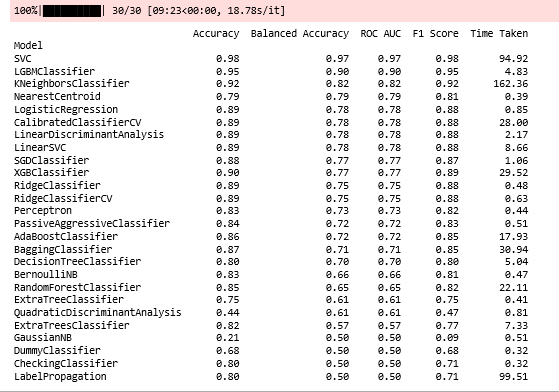

In [1]:
# system time for kaggle notebook was way too long to run, import results from local
from IPython import display 
display.Image("/kaggle/input/modelimage/modeltest.PNG")

In [ ]:
# Scaler : scale to [0,1] as dataset was NOT centroalized to 0
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
mscaler = MinMaxScaler() 
X_ms=mscaler.fit_transform(X)

# PCA dimension reduction
from sklearn.decomposition import PCA
pca = PCA(73)
pca.fit(X_ms)
np.cumsum(pca.explained_variance_ratio_) 
# require 73 pcas to retain 90% of total information and top 2 pcas each covers limited amount of information - up to 0.21

# LDA dimension reduction
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_u = LinearDiscriminantAnalysis() # n_components cannot be larger than min(n_features, n_classes - 1)
projectedl_u=lda_u.fit(X, y).transform(X)
lda_1 =pd.Series(np.transpose(projectedl_u)[0], name ='LDA1')
refu = y.replace({0:'N', 1:'Y'})
dftul = pd.concat([lda_1 , refu], axis=1)
sns.pairplot(dftul,hue='y', plot_kws={'alpha': 0.5})

- do not see clear margin of separation based on LDA, PCA(3d)
- high dimensional space, 70+ after PCA
#### SVM had best performance from the test run and good at hgh dimensional space and seperating margine
## Model 1 SVM

In [ ]:
# Prepare validation set
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
print(Counter(y_train))

# Balancing data REDUCE performance !!DO NOT Balance data
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#over = SMOTE(sampling_strategy=0.5)
#under = RandomUnderSampler(sampling_strategy=0.5)
#steps = [('o', over), ('u', under)]

# scale data
pipeline2 = Pipeline(
[('mmscale', MinMaxScaler() )])
# PCA 73 lost 10% information REDUCE performance !!DO NOT reduce dimension for SVM
# , ('pca', PCA(73))])
X_train = pipeline2.fit_transform(X_train)
X_test = pipeline2.transform(X_test)

In [ ]:
# Mannual grid search for best parameter
from sklearn.model_selection import GridSearchCV
from sklearn.svm import  SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score
  
# defining parameter range 
param_grid = {'C': [1, 10, 100, 1000],  # 1000 takes significant computing time
              'gamma': [1, 0.1, 0.01, 'scale'], 
              'kernel': ['rbf', 'sigmoid'],
              'degree': [1,2,3]
             }   
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, scoring='roc_auc') 
# fitting the model for grid search 
grid.fit(X_train, y_train)

# print best parameter after tuning 
print(grid.best_params_) 
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

y_predg = grid.predict(X_test)
print(f'Area Under Curve: {roc_auc_score(y_test, y_predg)}')
print(classification_report(y_test, y_predg))

#SVC(default)
#{'C': 1.0, 'class_weight': None,  # 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': None}
#AUC: 0.8081950106371
#weighted accuracy: 0.90

#SVC(C=1000, gamma=0.01, degree=3, kernel='rbf')
#AUC: 0.8564275553656884
#weighted accuracy: 0.92

#best parameter
#SVC(C=100, gamma=0.1, degree=3, kernel='rbf')
#AUC: 0.8851907734709265
#weighted accuracy: 0.93

In [ ]:
# Further automated grid search for parameter
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import  SVC
#!pip install skopt
import skopt
from skopt import BayesSearchCV
params = dict()
params['C'] = (50.0, 150.0, 'log-uniform')
params['gamma'] = (0.005, 0.15, 'log-uniform')
#params['degree'] = (1,5)
#params['kernel'] = ['rbf', 'sigmoid']
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=10)
# define the search
search = BayesSearchCV(estimator=SVC(degree=3, kernel='rbf', probability=True), search_spaces=params, n_jobs=-1, cv=cv, scoring='roc_auc')
# perform the search
search.fit(X_train, y_train)
# report the best result
print(search.best_score_)
print(search.best_params_)

In [ ]:
#chose model based on roc_auc score
# no scale no pca 0.5
# scale and pca 0.89

# BEST scale without pca ROC AUC 0.97
from sklearn.svm import  SVC
model = SVC(C=100, gamma=0.1, degree=3, kernel='rbf', probability=True)
model.fit(X_train, y_train)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score
y_pred = model.predict(X_test)
#print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
y_pred_prob = model.predict_proba(X_test)

print(f'Area Under Curve based on predicted results: {roc_auc_score(y_test, y_pred)}')
print(f'Area Under Curve based on SVM estimated probability: {roc_auc_score(y_test,pd.DataFrame(y_pred_prob).reset_index()[1])}')

from sklearn.metrics import accuracy_score, balanced_accuracy_score,confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score

print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Balanced Accuracy Score: {balanced_accuracy_score(y_test,y_pred)}')
print(f'F1 score: {f1_score(y_test,y_pred)}')
print(f'F1 Weighted score: {f1_score(y_test,y_pred, average="weighted" )}')
print(f'Recall score: {recall_score(y_test,y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'PR AUC: {average_precision_score(y_test, y_pred)}')

In [ ]:
# lift chart
df=pd.DataFrame(y_pred_prob)
df['predicted']=df[1]
df['response']=pd.DataFrame(y_test).reset_index()['y']
# rank observations by predicted probability
df['group'] = pd.qcut(df['predicted'], 20, labels=False, duplicates='drop')
df['group'] = df['group'].max() - df['group'] + 1
# lift table 
lift_table = df.groupby('group').agg({'response':['count','sum'], 'predicted':['min','max']})
lift_table.columns = ['count','response','min_score','max_score']
# cumulative counts
cumulative = {}
for i in lift_table.index:
    cumulative[i] = {'cumulative_response': lift_table['response'][lift_table.index <= i].sum(),
                     'cumulative_count': lift_table['count'][lift_table.index <= i].sum()}
cumulative = pd.DataFrame(cumulative).transpose()
lift_table = pd.merge(lift_table, cumulative, left_index=True, right_index=True)
# cumulative percent, recall, accuracy, lift
total_count = len(df)
total_response = lift_table['response'].sum()
lift_table['cumulative_percent'] = lift_table['cumulative_count'] / total_count
lift_table['cumulative_recall'] = lift_table['cumulative_response'] / total_response
lift_table['cumulative_accuracy'] = lift_table['cumulative_response'] / lift_table['cumulative_count']
lift_table['cumulative_lift'] = lift_table['cumulative_recall'] / lift_table['cumulative_percent']
lift_table

#### Final SVM Model 1
- Transformation: 

min-max scale without dimensional reduction
- Final Model and parameter: 
Support Vector Machine with Radial Basis Function kernel, C regularsation as 100, hyperplane (degree) has less impact in this case

- Select reasons: 
Model was selected based on best ROC_AUC score (depend on calculation method range from 0.97-0.99), and balanced accuracy (0.98). As shown in lift chart, top 20% of test population with highest probability could capture almost 95% actual true response. As we do not have further information about the predict response, if focus on capturing actual predicted true (eg, identify covid paitent), chose high Recall.

### Model 2 ANN-MLP
as PCA could not significantly reduce dimension while keep enough information test deep learning artificial neural network multilayer perceptron (ANN MLP) as alternative high dimensional efficiency model

In [ ]:
# load data and prepare array
import pandas as pd
import numpy as np
# import as array
fname ='/kaggle/input/classification-dataset/exercise_05_train_prepy.csv'
all_features = []
all_targets = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0:
            #print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])
        #if i == 1:
            #print("EXAMPLE FEATURES:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

# validation set
num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))

#data balancy
counts = np.bincount(train_targets[:, 0])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)))

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

In [ ]:
# normalize data
mean = np.mean(train_features, axis=0)
meant=mean.copy()
print(mean[:5])
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
stdt=std.copy()
print(std[:5])
train_features /= std
val_features /= std

In [ ]:
#build model and tune hidden-layer
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(256, activation="relu", input_shape=(train_features.shape[-1],)),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        
        # tested, dropout rate shows best at 0.3 among [0.2-0.5]
        
        # tested, do not neet additional hidden layer
        ##keras.layers.Dense(256, activation="relu"),
        ##keras.layers.Dropout(0.1),
        
        keras.layers.Dense(1, activation="sigmoid"), #'sigmoid', 'softmax'
    ]
)
model.summary()

In [ ]:
#compile model and tune parameters
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall")
    #keras.metrics.AUC(name ='AUC') # keras seemed to have issue with this metric
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    train_features,
    train_targets,
    batch_size=2048, #500, 2000
    epochs=30, #20, 30, 100
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight
)

#alternative AUC_ROC score
from sklearn.metrics import roc_auc_score
y_pred = model.predict_proba(val_features)
print(roc_auc_score(val_targets, y_pred)) #0.9843862664204388

In [ ]:
df['predicted']=pd.DataFrame(y_pred)
df['response']=val_targets
# rank observations by predicted probability
df['group'] = pd.qcut(df['predicted'], 20, labels=False, duplicates='drop')
df['group'] = df['group'].max() - df['group'] + 1
# lift table 
lift_table = df.groupby('group').agg({'response':['count','sum'], 'predicted':['min','max']})
lift_table.columns = ['count','response','min_score','max_score']
# cumulative counts
cumulative = {}
for i in lift_table.index:
    cumulative[i] = {'cumulative_response': lift_table['response'][lift_table.index <= i].sum(),
                     'cumulative_count': lift_table['count'][lift_table.index <= i].sum()}
cumulative = pd.DataFrame(cumulative).transpose()
lift_table = pd.merge(lift_table, cumulative, left_index=True, right_index=True)
# cumulative percent, recall, accuracy, lift
total_count = len(df)
total_response = lift_table['response'].sum()
lift_table['cumulative_percent'] = lift_table['cumulative_count'] / total_count
lift_table['cumulative_recall'] = lift_table['cumulative_response'] / total_response
lift_table['cumulative_accuracy'] = lift_table['cumulative_response'] / lift_table['cumulative_count']
lift_table['cumulative_lift'] = lift_table['cumulative_recall'] / lift_table['cumulative_percent']
lift_table

# Step 3 - Generate predictions
prepare test set
predict with SVM
predict with ANN MLP

In [ ]:
# svm m1
# predict test set
X_test_p = pipeline2.transform(Xt)
yt_pred_prob = model.predict_proba(X_test_p)
# ann m2
# predict test set
fname ='exercise_05_test_prepy.csv'
t_features = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0:
            #print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        t_features.append([float(v.replace('"', "")) for v in fields[:]])

test_features = np.array(t_features, dtype="float32")

print("features.shape:", test_features.shape)

#normalize data
test_features -= meant
test_features /= stdt
#predict results
yt_pred = model.predict_proba(test_features)

# Step 4 - Compare models

Multiple models were tested and SVM(support-vector machine) and ANN MLP*(artificial neural network multilayer perceptron) were selected for their best predicting performance, scored by ROC_AUC and balanced accuracy. Both SVM and ANN MLP have similar Accuracy and F1 score, ANN MLP has higher recall. However, which score should be used to evaluate model performance depends on business requirements. If the analysis meant to identify patient, accident or fraud, high recall would be preferred. Otherwise, if the analysis meant for promotion and low-cost advertising, high precision would be better.
There are pros and cons for each model
##### SVM Pros
SVM works more effective in high dimensional space (large number of attributes).
SVM has low bias while provides regularisation parameter C*** to prevent over-fitting and improve generalization capability.
SVM has strong stability and good performance in this analysis.
Compared to ANN, no local minimum.
##### SVM Cons
Time: To achieve accurate prediction, C needs to be high and will require long computing time to fine tune.
Probability Estimation: SVM does not generate probability, probability has to be estimated with Platt scaling.
Scaling: MUST scale data before applying SVM.
Interpretation: Not easy to visualize and interpretate as other algorithms.

##### ANN MLP Pros
Capability of handle massive amount of data with parallel process and distributed memory.
Capture complex relationship among data and generalize it to unseen data (high predicting performance).
Efficient learning with only passing important information to next layer. -- Compared to SVM, capability of on-line learning
##### ANN MLP Cons
Require hardware for batching process
Exists local minimum caused by different random weight initializations
Time: To achieve accurate prediction, require long computing time to fine tune.
Scaling: MUST scale data
Interpretation: Not easy to visualize and interpretate as other algorithms.


To achieve the best performance, ensemble method could be applied:
When SVM and ANN MLP has different results, depend on the business requirement, a. if objective is to identify accident, fraud or not capturing actual true event could be costly, use ANN MLP for its high performance in capturing most actual true event (higher recall score); b. if objective is to promote, recruit or target actual true even with fixed sample, use SVM for its higher precision score.